# Getting Started with AstroPhot

In this notebook you will walk through the very basics of AstroPhot functionality. Here you will learn how to make models; how to set them up for fitting; and how to view the results. These core elements will come up every time you use AstroPhot, though in future notebooks you will learn how to take advantage of the advanced features in AstroPhot.

In [1]:
import os
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

## Your first model

The basic format for making an AstroPhot model is given below. Once a model object is constructed, it can be manipulated and updated in various ways.

In [2]:
model1 = ap.models.AstroPhot_Model(
    name = "model1", # every model must have a unique name
    model_type = "sersic galaxy model", # this specifies the kind of model
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1}, # here we set initial values for each parameter
    target = ap.image.Target_Image(data = np.zeros((100,100)), zeropoint = 22.5, pixelscale = 1.), # every model needs a target, more on this later
)
model1.initialize() # before using the model it is good practice to call initialize so the model can get itself ready

# We can print the model's current state
print(model1)

model_type: sersic galaxy model
name: model1
parameters:
  name: model1
  parameter_order:
  - center
  - q
  - PA
  - n
  - Re
  - Ie
  parameters:
    Ie:
      identity: '140493131298512'
      name: Ie
      units: log10(flux/arcsec^2)
      value: 1.0
    PA:
      cyclic: true
      identity: '140493131298368'
      limits: !!python/tuple
      - 0.0
      - 3.141592653589793
      name: PA
      uncertainty: 0.06
      units: radians
      value: 1.0471975511965976
    Re:
      identity: '140493131298464'
      limits: !!python/tuple
      - 0.0
      - null
      name: Re
      units: arcsec
      value: 10.0
    center:
      identity: '140497209254576'
      name: center
      uncertainty:
      - 0.1
      - 0.1
      units: arcsec
      value:
      - 50.0
      - 50.0
    n:
      identity: '140493131298416'
      limits: !!python/tuple
      - 0.36
      - 8.0
      name: n
      uncertainty: 0.05
      units: none
      value: 2.0
    q:
      identity: '140493131298176

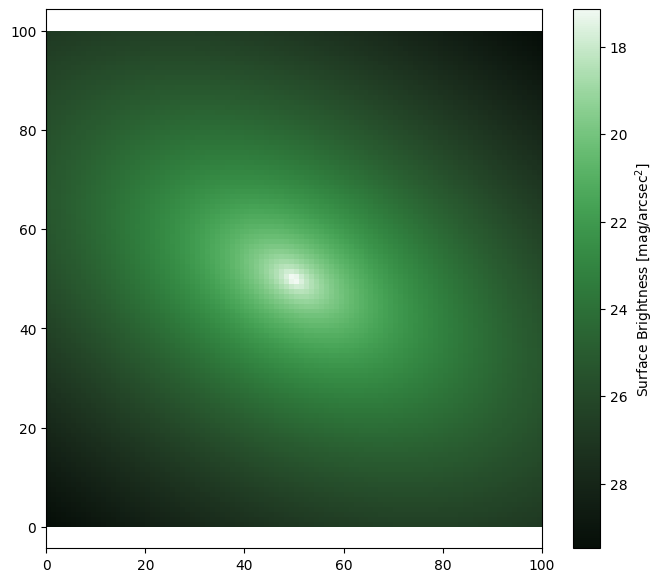

In [3]:
# AstroPhot has built in methods to plot relevant information. We didn't specify the region on the sky for
# this model to focus on, so we just made a 100x100 window. Unless you are very lucky this wont
# line up with what you're trying to fit, so next we'll see how to give the model a target.

fig, ax = plt.subplots(figsize = (8,7))
ap.plots.model_image(fig, ax, model1)
plt.show()

## Giving the model a Target

Typically, the main goal when constructing an AstroPhot model is to fit to an image. We need to give the model access to the image and some information about it to get started.

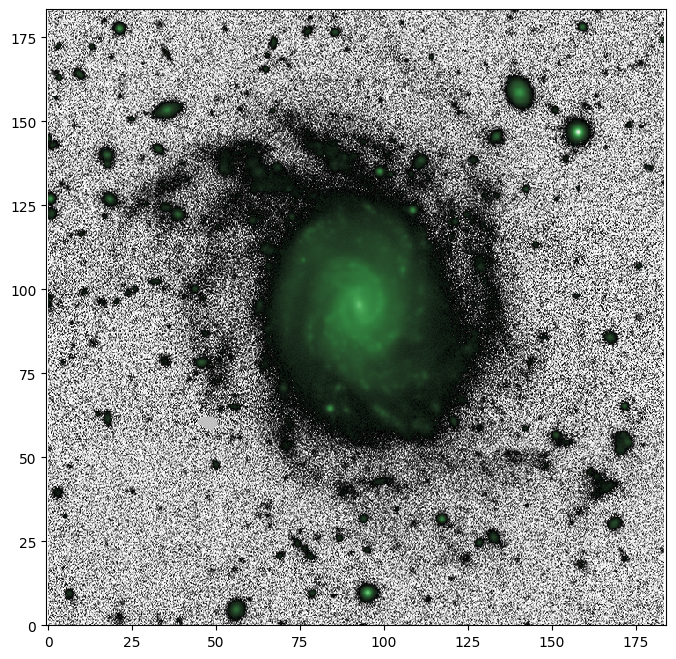

In [4]:
# first let's download an image to play with
hdu = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=36.3684&dec=-25.6389&size=700&layer=ls-dr9&pixscale=0.262&bands=r")
target_data = np.array(hdu[0].data, dtype = np.float64)

# Create a target object with specified pixelscale and zeropoint
target = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.262, # Every target image needs to know it's pixelscale in arcsec/pixel
    zeropoint = 22.5, # optionally, you can give a zeropoint to tell AstroPhot what the pixel flux units are
    variance = np.ones(target_data.shape)/1e3, # set the variance for this image (in general it should be more accurate than this)
)

# The default AstroPhot target plotting method uses log scaling in bright areas and histogram scaling in faint areas
fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig3, ax3, target)
plt.show()

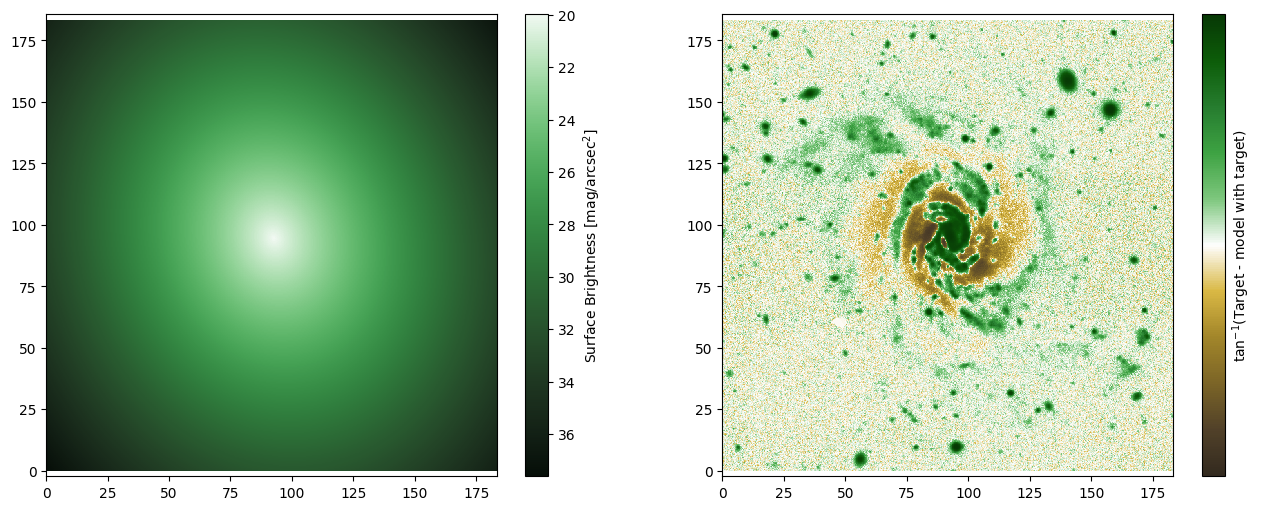

In [5]:
# This model now has a target that it will attempt to match
model2 = ap.models.AstroPhot_Model(
    name = "model with target", 
    model_type = "sersic galaxy model", # feel free to swap out sersic with other profile types
    target = target, # now the model knows what its trying to match
)

# Instead of giving initial values for all the parameters, it is possible to simply call "initialize" and AstroPhot 
# will try to guess initial values for every parameter assuming the galaxy is roughly centered. It is also possible
# to set just a few parameters and let AstroPhot try to figure out the rest. For example you could give it an initial
# Guess for the center and it will work from there.
model2.initialize()

# Plotting the initial parameters and residuals, we see it gets the rough shape of the galaxy right, but still has some fitting to do
fig4, ax4 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig4, ax4[0], model2)
ap.plots.residual_image(fig4, ax4[1], model2)
plt.show()

In [6]:
# Now that the model has been set up with a target and initialized with parameter values, it is time to fit the image
result = ap.fit.LM(model2, verbose = 1).fit()

# See that we use ap.fit.LM, this is the Levenberg-Marquardt Chi^2 minimization method, it is the recommended technique
# for most least-squares problems. However, there are situations in which different optimizers may be more desireable
# so the ap.fit package includes a few options to pick from. The various fitting methods will be described in a 
# different tutorial.
print("Fit message:",result.message) # the fitter will return a message about its convergence

Chi^2: 4.48293664241283, L: 1.0
Chi^2: 4.340965139053397, L: 0.3333333333333333
Chi^2: 4.320538186003468, L: 0.1111111111111111
Chi^2: 4.313993647704852, L: 0.012345679012345678
Chi^2: 4.3128774306962185, L: 1.693508780843029e-05
Chi^2: 4.3128696674432145, L: 2.0907515812876902e-07
Final Chi^2: 4.312869603760238, L: 2.323057312541878e-08. Converged: success
Fit message: success


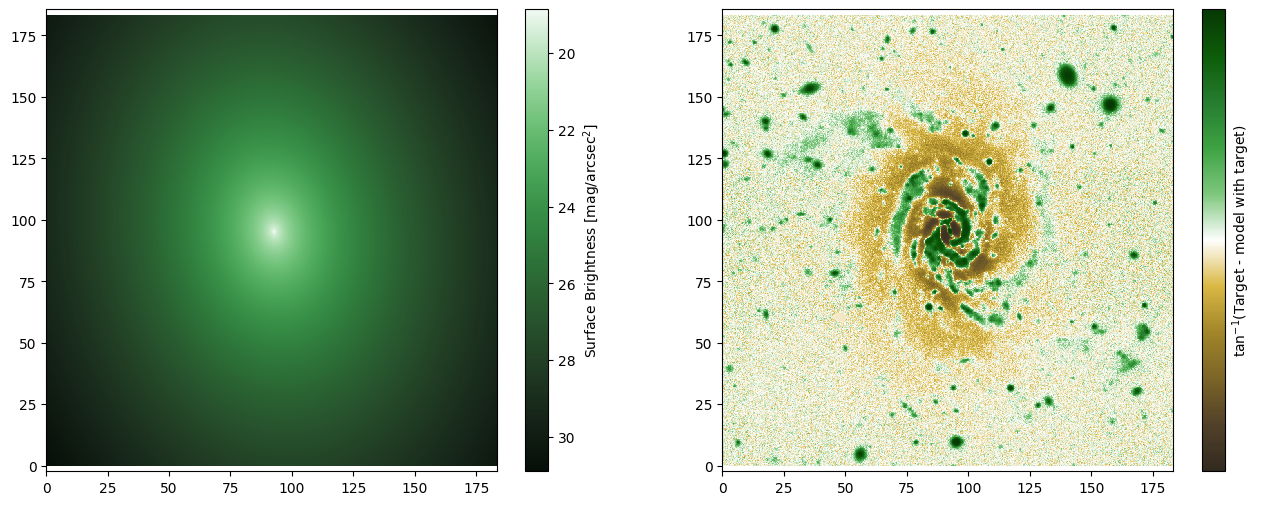

In [7]:
# we now plot the fitted model and the image residuals
fig5, ax5 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig5, ax5[0], model2)
ap.plots.residual_image(fig5, ax5[1], model2)
plt.show()

/home/connor/Programming/AstroPhot/astrophot/utils/conversions/units.py:16: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + zeropoint + 2.5 * np.log10(pixel_area)


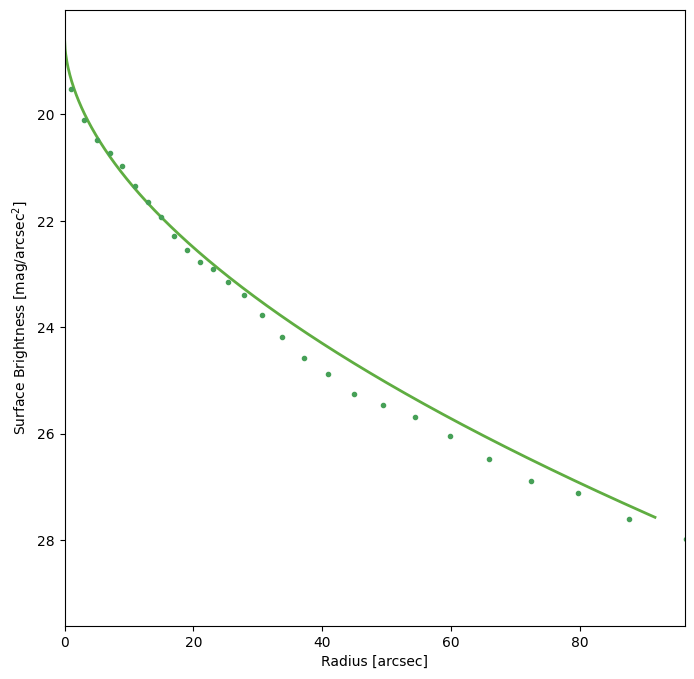

In [8]:
# Plot surface brightness profile

# we now plot the model profile and a data profile. The model profile is determined from the model parameters
# the data profile is determined by taking the median of pixel values at a given radius. Notice that the model
# profile is slightly higher than the data profile? This is because there are other objects in the image which
# are not being modelled, the data profile uses a median so they are ignored, but for the model we fit all pixels.
fig10, ax10 = plt.subplots(figsize = (8,8))
ap.plots.radial_light_profile(fig10, ax10, model2)
ap.plots.radial_median_profile(fig10, ax10, model2)
plt.show()

## Update uncertainty estimates

After running a fit, the `ap.fit.LM` optimizer can update the uncertainty for each parameter. In fact it can return the full covariance matrix if needed. For a demo of what can be done with the covariance matrix see the `FittingMethods` tutorial. One important note is that the variance image needs to be correct for the uncertainties to be meaningful!

In [9]:
result.update_uncertainty()
for P in model2.parameters:
    print(f"parameter {P.name} is: {P.value.detach().cpu().tolist()} +- {P.uncertainty.detach().cpu().tolist()}")

parameter center is: [92.75304524252724, 95.23030464324538] +- [0.0043593276477004025, 0.006031277936460883]
parameter q is: 0.7413436288335258 +- 0.0019329073535287963
parameter PA is: 0.13901960644696518 +- 0.004291065784755045
parameter n is: 1.8400455363598476 +- 0.0059404525654490675
parameter Re is: 17.280341606010296 +- 0.0711542841646977
parameter Ie is: 0.1207132121716288 +- 0.0027468628866286556


Note that these uncertainties are pure statistical uncertainties that come from evaluating the structure of the $\chi^2$ minimum. Systematic uncertainties are not included and these often significantly outweigh the standard errors. As can be seen in the residual plot above, there is certainly plenty of unmodelled structure there. Use caution when interpreting the errors from these fits.

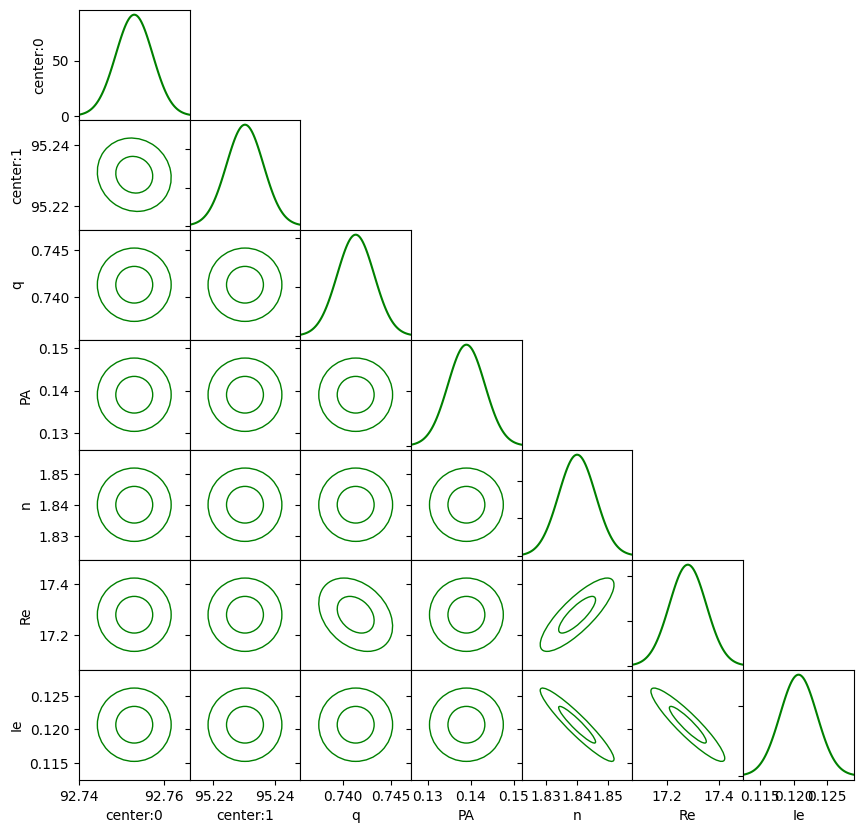

In [10]:
# Plot the uncertainty matrix

# While the scale of the uncertainty may not be meaningful if the image variance is not accurate, we 
# can still see how the covariance of the parameters plays out in a given fit.
fig, ax = ap.plots.covariance_matrix(
    result.covariance_matrix.detach().cpu().numpy(), 
    model2.parameters.get_vector().detach().cpu().numpy(), 
    model2.parameters.get_name_vector()
)
plt.show()

## Giving the model a specific target window

Sometimes an object isn't nicely centered in the image, and may not even be the dominant object in the image. It is therefore nice to be able to specify what part of the image we should analyze.

automatically generated name: sersic galaxy model [0]


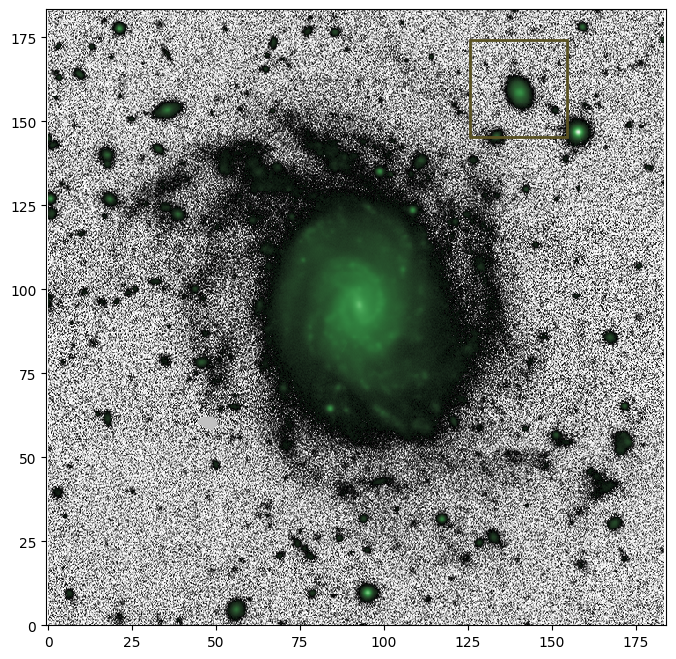

In [11]:
# note, we don't provide a name here. A unique name will automatically be generated using the model type
model3 = ap.models.AstroPhot_Model(
    model_type = "sersic galaxy model",
    target = target,
    window = [[480, 590],[555, 665]], # this is a region in pixel coordinates ((xmin,xmax),(ymin,ymax)) 
)
print("automatically generated name:", model3.name)

# We can plot the "model window" to show us what part of the image will be analyzed by that model
fig6, ax6 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig6, ax6, model3.target)
ap.plots.model_window(fig6, ax6, model3)
plt.show()

In [12]:
model3.initialize()

result = ap.fit.LM(model3, verbose = 1).fit()
print(result.message)

Chi^2: 0.6306517521958812, L: 1.0
Chi^2: 0.5768732480874624, L: 1.6666666666666667
Chi^2: 0.5611592168271133, L: 2.777777777777778
Chi^2: 0.35386621793252415, L: 0.925925925925926
Chi^2: 0.3066375912069377, L: 1.5432098765432098
Chi^2: 0.11194634732083965, L: 0.51440329218107
Chi^2: 0.06740403934062014, L: 0.17146776406035666
Chi^2: 0.05062128366068083, L: 0.05715592135345222
Chi^2: 0.040542697095258706, L: 0.01905197378448407
Chi^2: 0.037063408479040584, L: 0.006350657928161357
Chi^2: 0.037012986856505406, L: 8.71146492203204e-06
Chi^2: 0.037012544869801906, L: 1.1949883294968506e-08
Chi^2: 0.03701253957857193, L: 3.9832944316561685e-09
Final Chi^2: 0.03701253953853439, L: 3.9832944316561685e-09. Converged: success
success


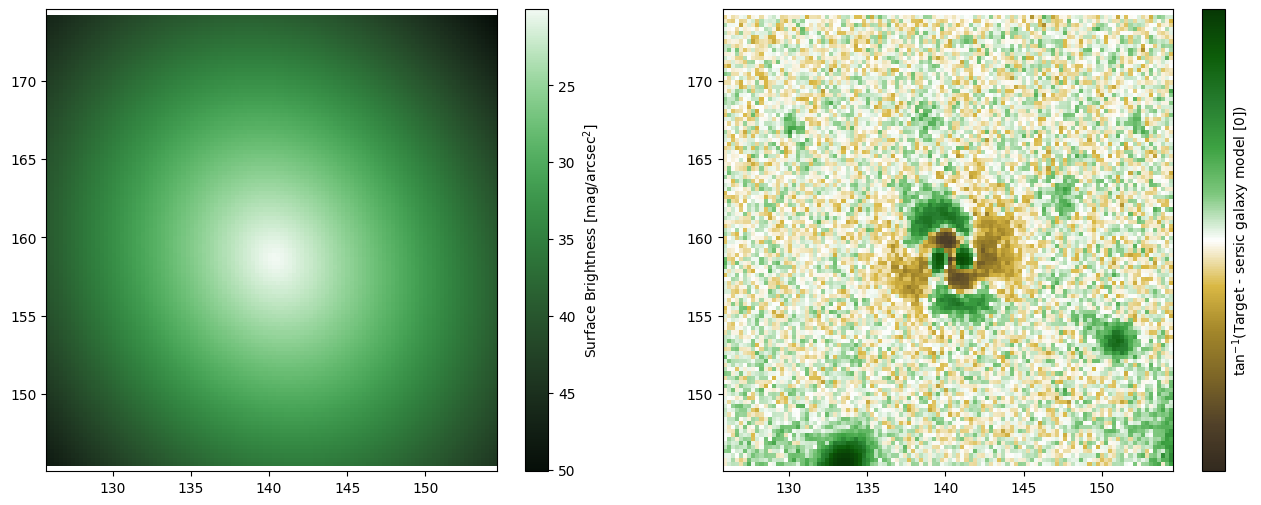

In [13]:
# Note that when only a window is fit, the default plotting methods will only show that window
fig7, ax7 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig7, ax7[0], model3)
ap.plots.residual_image(fig7, ax7[1], model3)
plt.show()

## Setting parameter constraints

A common feature of fitting parameters is that they have some constraint on their behaviour and cannot be sampled at any value from (-inf, inf). AstroPhot circumvents this by remapping any constrained parameter to a space where it can take any real value, at least for the sake of fitting. For most parameters these constraints are applied by default; for example the axis ratio q is required to be in the range (0,1). Other parameters, such as the position angle (PA) are cyclic, they can be in the range (0,pi) but also can wrap around. It is possible to manually set these constraints while constructing a model.

In general adding constraints makes fitting more difficult. There is a chance that the fitting process runs up against a constraint boundary and gets stuck. However, sometimes adding constraints is necessary and so the capability is included.

In [14]:
# here we make a sersic model that can only have q and n in a narrow range
# Also, we give PA and initial value and lock that so it does not change during fitting
constrained_param_model = ap.models.AstroPhot_Model(
    name = "constrained parameters", model_type = "sersic galaxy model", 
    parameters = {
        "q": {"limits": [0.4,0.6]}, 
        "n": {"limits": [2,3]}, 
        "PA": {"value": 60*np.pi/180, "locked": True},
    }
)

Aside from constraints on an individual parameter, it is sometimes desireable to have different models share parameter values. For example you may wish to combine multiple simple models into a more complex model (more on that in a different tutorial), and you may wish for them all to have the same center. This can be accomplished with "equality constraints" as shown below.

In [15]:
# model 1 is a sersic model
model_1 = ap.models.AstroPhot_Model(
    model_type = "sersic galaxy model",
    parameters = {"center": [50,50], "PA": np.pi/4}
)
# model 2 is an exponential model
model_2 = ap.models.AstroPhot_Model(
    model_type = "exponential galaxy model",
)

# Here we add the constraint for "PA" to be the same for each model.
# In doing so we provide the model and parameter name which should 
# be connected.
model_2.add_equality_constraint(model_1, "PA")

# Here we can see how the two models now both can modify this parameter
print("initial values: model_1 PA", model_1["PA"].value.item(), "model_2 PA", model_2["PA"].value.item())
# Now we modify the PA for model_1
model_1["PA"].value = np.pi/3
print("change model_1: model_1 PA", model_1["PA"].value.item(), "model_2 PA", model_2["PA"].value.item())
# Similarly we modify the PA for model_2
model_2["PA"].value = np.pi/2
print("change model_2: model_1 PA", model_1["PA"].value.item(), "model_2 PA", model_2["PA"].value.item())

initial values: model_1 PA 0.7853981633974483 model_2 PA 0.7853981633974483
change model_1: model_1 PA 1.0471975511965976 model_2 PA 1.0471975511965976
change model_2: model_1 PA 1.5707963267948966 model_2 PA 1.5707963267948966


In [16]:
# Keep in mind that both models have full control over the parameter, it is listed in both of
# their "parameter_order" tuples. 
print("model_1 parameters: ", model_1.parameter_order)
print("model_2 parameters: ", model_2.parameter_order)

model_1 parameters:  ('center', 'q', 'PA', 'n', 'Re', 'Ie')
model_2 parameters:  ('center', 'q', 'Re', 'Ie', 'PA')


## PSF convolution

An important part of astronomical image analysis is accounting for PSF effects. To that end, AstroPhot includes a number of approaches to handle PSF convolution. The main concept is that AstroPhot will convolve its model with a PSF before comparing against an image. The PSF behaviour of a model is determined by the *psf_mode* parameter which can be set before fitting.

psf mode:  full


/home/connor/Programming/AstroPhot/astrophot/utils/conversions/units.py:16: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + zeropoint + 2.5 * np.log10(pixel_area)


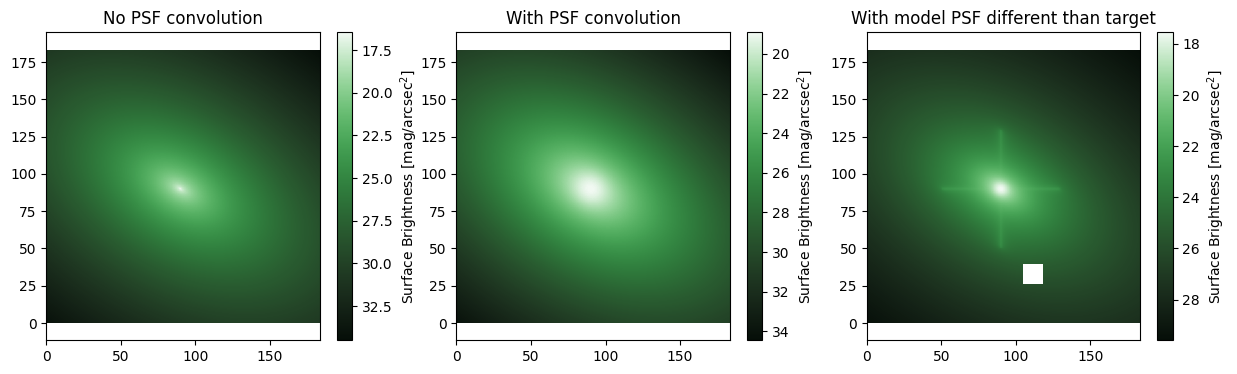

In [17]:
# first a psf is needed, this is stored with the target object
# Here we simply construct a gaussian PSF image that is 31 pixels across
# Note the PSF must always be odd in its dimensions
xx, yy = np.meshgrid(np.linspace(-5,5,301), np.linspace(-5,5,301))
PSF = np.exp(-(xx**2 + yy**2)/0.8**2)
PSF /= np.sum(PSF)
PSF = ap.image.PSF_Image(data=PSF, pixelscale = 0.262)
target = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.262,
    zeropoint = 22.5,
    psf = PSF,
)

model_nopsf = ap.models.AstroPhot_Model(
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [90,90], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1},
    psf_mode = "none", # no PSF convolution will be done
)
model_psf = ap.models.AstroPhot_Model(
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [90,90], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1},
    psf_mode = "full", # now the full window will be PSF convolved
)

PSF2 = np.exp(-(xx**2 + yy**2)/0.4**2)
PSF2[:,148:153] += 0.01
PSF2[148:153,:] += 0.01
PSF2 /= np.sum(PSF2)
PSF2 = ap.image.PSF_Image(data=PSF2, pixelscale = 0.262)
model_mask = torch.zeros_like(target.data)
model_mask[100:150,400:450] = 1
model_selfpsf = ap.models.AstroPhot_Model( 
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [90,90], "q": 0.6, "PA": 60*np.pi/180, "n": 4, "Re": 10, "Ie": 1},
    psf_mode = "full", 
    psf = PSF2, # Now this model has its own PSF, instead of using the target psf
    mask = model_mask, # Now this model has its own mask, *as well as* the target mask
)
print("psf mode: ", model_psf.psf_mode)

# With a convolved sersic the center is much more smoothed out
fig, ax = plt.subplots(1,3,figsize = (15,4))
ap.plots.model_image(fig, ax[0], model_nopsf)
ax[0].set_title("No PSF convolution")
ap.plots.model_image(fig, ax[1], model_psf)
ax[1].set_title("With PSF convolution")
ap.plots.model_image(fig, ax[2], model_selfpsf)
ax[2].set_title("With model PSF different than target")
plt.show()
# the warning below is just because the model mask values are zero and the plot is in log scale

## Basic things to do with a model

Now that we know how to create a model and fit it to an image, lets get to know the model a bit better.

In [18]:
# Save the model to a file

model2.save() # will default to save as AstroPhot.yaml

with open("AstroPhot.yaml", "r") as f:
    print(f.read()) # show what the saved file looks like

model_type: sersic galaxy model
name: model with target
parameters:
  name: model with target
  parameter_order:
  - center
  - q
  - PA
  - n
  - Re
  - Ie
  parameters:
    Ie:
      identity: '140493131214464'
      name: Ie
      uncertainty: 0.0027468628866286556
      units: log10(flux/arcsec^2)
      value: 0.1207132121716288
    PA:
      cyclic: true
      identity: '140493103339888'
      limits: !!python/tuple
      - 0.0
      - 3.141592653589793
      name: PA
      uncertainty: 0.004291065784755045
      units: radians
      value: 0.13901960644696518
    Re:
      identity: '140493131213936'
      limits: !!python/tuple
      - 0.0
      - null
      name: Re
      uncertainty: 0.0711542841646977
      units: arcsec
      value: 17.280341606010296
    center:
      identity: '140493096840544'
      name: center
      uncertainty:
      - 0.0043593276477004025
      - 0.006031277936460883
      units: arcsec
      value:
      - 92.75304524252724
      - 95.23030464324538

In [19]:
# load a model from a file

# note that the target still must be specified, only the parameters are saved
model4 = ap.models.AstroPhot_Model(name = "new name", filename = "AstroPhot.yaml", target = target)
print(model4) # can see that it has been constructed with all the same parameters as the saved model2.

model_type: sersic galaxy model
name: new name
parameters:
  name: model with target
  parameter_order:
  - center
  - q
  - PA
  - n
  - Re
  - Ie
  parameters:
    Ie:
      identity: '140493131214464'
      name: Ie
      uncertainty: 0.0027468628866286556
      units: log10(flux/arcsec^2)
      value: 0.1207132121716288
    PA:
      cyclic: true
      identity: '140493103339888'
      limits: !!python/tuple
      - 0.0
      - 3.141592653589793
      name: PA
      uncertainty: 0.004291065784755045
      units: radians
      value: 0.13901960644696518
    Re:
      identity: '140493131213936'
      limits: !!python/tuple
      - 0.0
      - null
      name: Re
      uncertainty: 0.0711542841646977
      units: arcsec
      value: 17.280341606010296
    center:
      identity: '140493096840544'
      name: center
      uncertainty:
      - 0.0043593276477004025
      - 0.006031277936460883
      units: arcsec
      value:
      - 92.75304524252724
      - 95.23030464324538
    n:
 

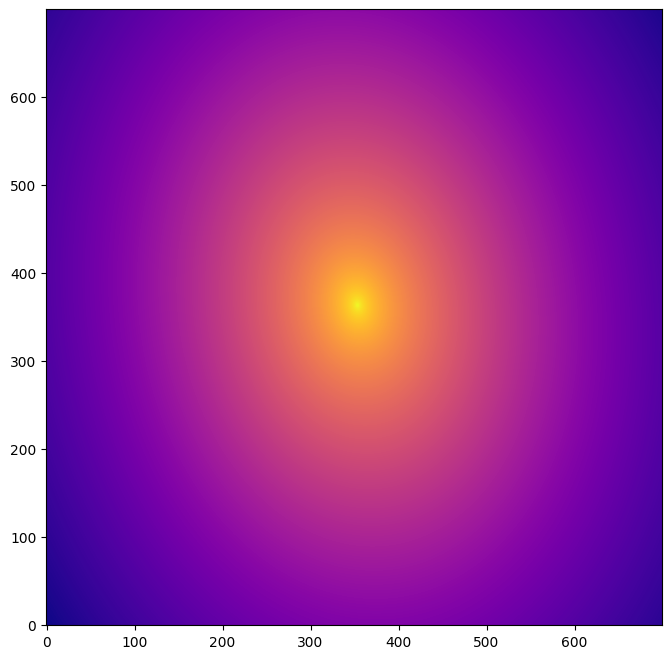

In [20]:
# Save the model image to a file

model_image_sample = model2()
model_image_sample.save("model2.fits")

saved_image_hdu = fits.open("model2.fits")
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(
    np.log10(saved_image_hdu[0].data), 
    origin = "lower",
    cmap = "plasma",
)
plt.show()

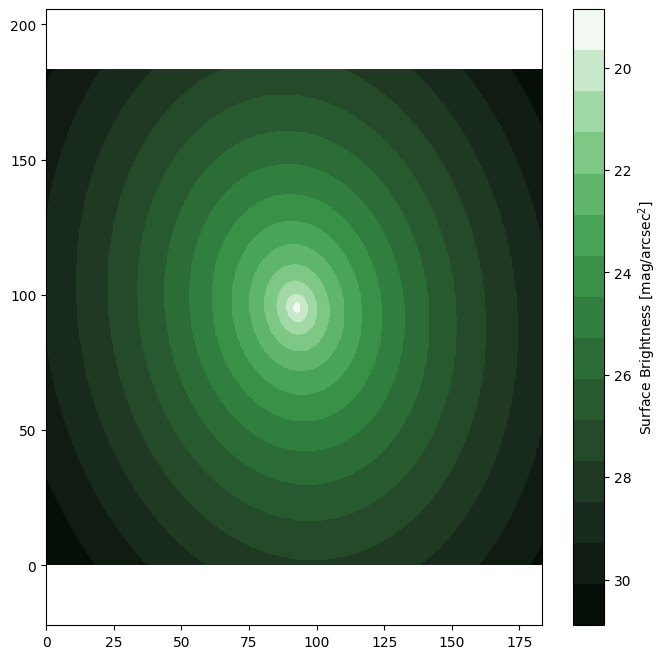

In [21]:
# Plot model image with discrete levels

# this is very useful for visualizing subtle features and for eyeballing the brightness at a given location.
# just add the "cmap_levels" keyword to the model_image call and tell it how many levels you want
fig11, ax11 = plt.subplots(figsize = (8, 8))
ap.plots.model_image(fig11, ax11, model2, cmap_levels = 15)
plt.show()

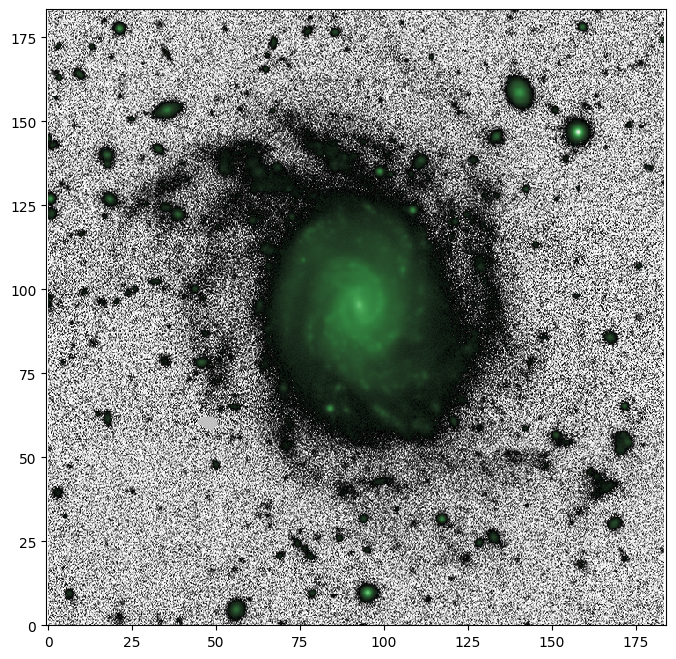

In [22]:
# Save and load a target image

target.save("target.fits")

new_target = ap.image.Target_Image(filename = "target.fits")

fig, ax = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig, ax, new_target)
plt.show()

parameter input order:  ('center', 'q', 'PA', 'n', 'Re', 'Ie')


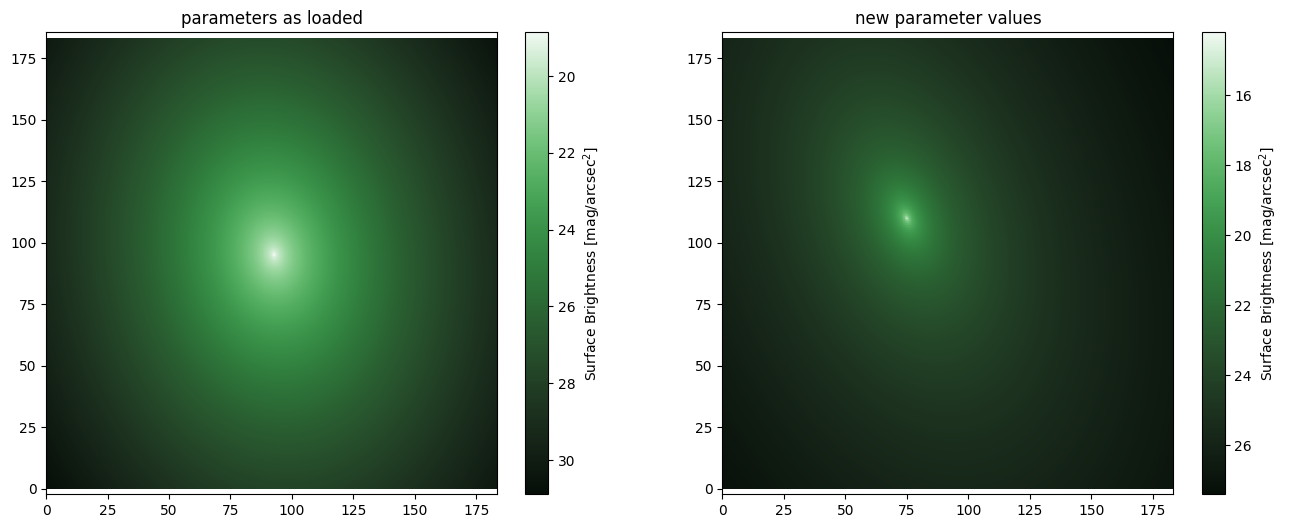

In [23]:
# Give the model new parameter values manually

print("parameter input order: ", model4.parameter_order) # use this to see what order you have to give the parameters as input

# plot the old model
fig9, ax9 = plt.subplots(1,2,figsize = (16,6))
ap.plots.model_image(fig9, ax9[0], model4)
T = ax9[0].set_title("parameters as loaded")

# update and plot the new parameters
new_parameters = torch.tensor([75, 110, 0.4, 20*np.pi/180, 3, 25, 0.12]) # note that the center parameter needs two values as input
model4.initialize() # initialize must be called before optimization, or any other activity in which parameters are updated
model4.parameters.set_values(new_parameters) # full_sample will update the parameters, then run sample and return the model image 
ap.plots.model_image(fig9, ax9[1], model4)
T = ax9[1].set_title("new parameter values")

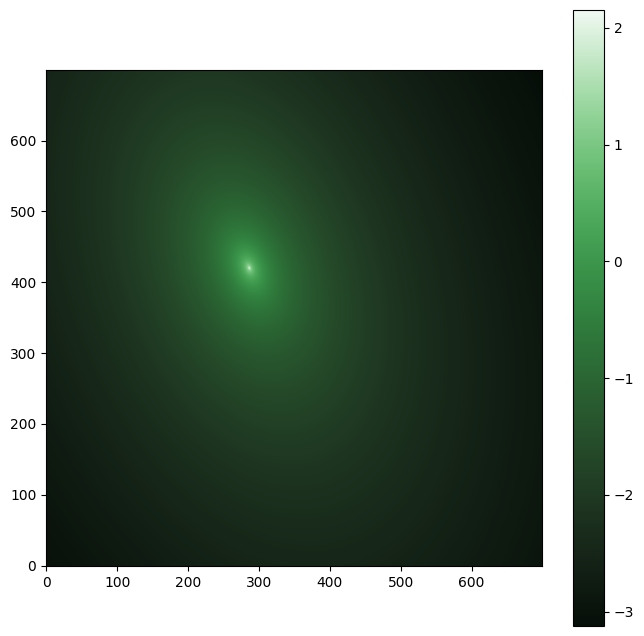

In [24]:
# Access the model image pixels directly

fig2, ax2 = plt.subplots(figsize = (8,8))

pixels = model4().data.detach().cpu().numpy()# model4.model_image.data is the pytorch stored model image pixel values. Calling detach().cpu().numpy() is needed to get the data out of pytorch and in a usable form

im = plt.imshow(
    np.log10(pixels), # take log10 for better dynamic range
    origin = "lower",
    cmap = ap.plots.visuals.cmap_grad, # gradient colourmap default for AstroPhot
)
plt.colorbar(im)
plt.show()

## Load target with WCS information

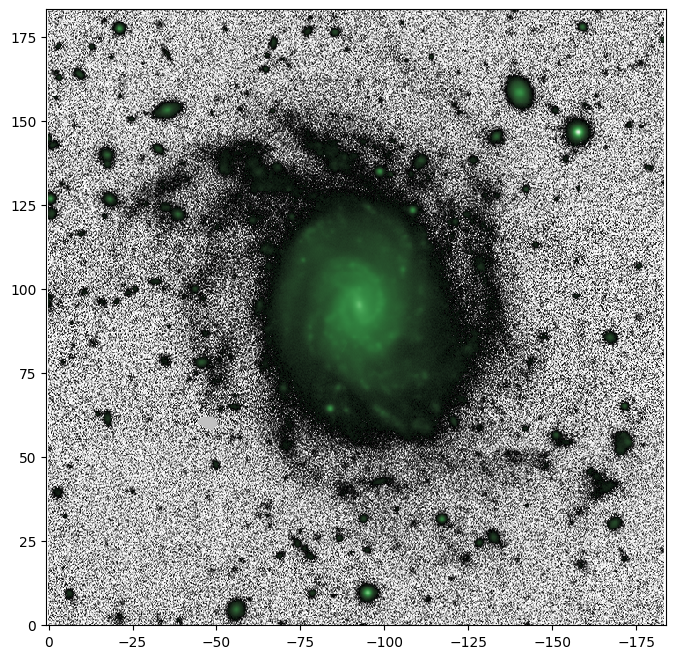

In [33]:
# first let's download an image to play with
hdu = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=36.3684&dec=-25.6389&size=700&layer=ls-dr9&pixscale=0.262&bands=r")
target_data = np.array(hdu[0].data, dtype = np.float64)

wcs = WCS(hdu[0].header)

# This sets our reference RA, DEC coordinates on-sky. See the coordinates explainer in the docs for more!
ref_loc = wcs.pixel_to_world(0,0)
target.header.reference_radec = (ref_loc.ra.deg, ref_loc.dec.deg)

# Create a target object with WCS which will specify the pixelscale and origin for us!
target = ap.image.Target_Image(
    data = target_data,
    zeropoint = 22.5,
    wcs = wcs,
)

fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig3, ax3, target, flipx=True) # note we flip the x-axis since RA coordinats are backwards 
plt.show()

In [27]:
# Models can be constructed by providing model_type, or by creating the desired class directly

#                     notice this is no longer "AstroPhot_Model"
model1_v2 = ap.models.Sersic_Galaxy(
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1},
    target = ap.image.Target_Image(data=np.zeros((100,100)), pixelscale = 1),
    psf_mode = "full", # only change is the psf_mode
)

# This will be the same as model1, except note that the "psf_mode" keyword is now tracked since it isn't a default value
print(model1_v2)

model_type: sersic galaxy model
name: sersic galaxy model [5]
parameters:
  name: sersic galaxy model [5]
  parameter_order:
  - center
  - q
  - PA
  - n
  - Re
  - Ie
  parameters:
    Ie:
      identity: '140492950519472'
      name: Ie
      units: log10(flux/arcsec^2)
      value: 1.0
    PA:
      cyclic: true
      identity: '140492979868432'
      limits: !!python/tuple
      - 0.0
      - 3.141592653589793
      name: PA
      uncertainty: 0.06
      units: radians
      value: 1.0471975511965976
    Re:
      identity: '140492950517312'
      limits: !!python/tuple
      - 0.0
      - null
      name: Re
      units: arcsec
      value: 10.0
    center:
      identity: '140492950120864'
      name: center
      uncertainty:
      - 0.1
      - 0.1
      units: arcsec
      value:
      - 50.0
      - 50.0
    n:
      identity: '140492979871072'
      limits: !!python/tuple
      - 0.36
      - 8.0
      name: n
      uncertainty: 0.05
      units: none
      value: 2.0
    q

In [28]:
# List all the available model names

# AstroPhot keeps track of all the subclasses of the AstroPhot_Model object, this list will 
# include all models even ones added by the user
print(ap.models.AstroPhot_Model.List_Model_Names(useable = True)) # set useable = None for all models, or useable = False for only base classes
print("---------------------------")
# It is also possible to get all sub models of a specific Type
print("only star models: ", ap.models.Star_Model.List_Model_Names())

['isothermal sech2 edgeon model', 'group model', 'sersic star model', 'zernike star model', 'spline star model', 'relspline star model', 'psf star model', 'exponential star model', 'gaussian star model', 'nuker star model', 'moffat star model', 'airy star model', 'plane sky model', 'flat sky model', 'sersic galaxy model', 'sersic wedge galaxy model', 'spline wedge galaxy model', 'exponential wedge galaxy model', 'gaussian wedge galaxy model', 'nuker wedge galaxy model', 'spline galaxy model', 'relspline galaxy model', 'sersic superellipse galaxy model', 'spline superellipse galaxy model', 'exponential superellipse galaxy model', 'gaussian superellipse galaxy model', 'nuker superellipse galaxy model', 'exponential galaxy model', 'gaussian galaxy model', 'sersic warp galaxy model', 'spline warp galaxy model', 'sersic superellipse warp galaxy model', 'spline superellipse warp galaxy model', 'exponential superellipse warp galaxy model', 'gaussian superellipse warp galaxy model', 'nuker sup

## Using GPU acceleration

This one is easy! If you have a cuda enabled GPU available, AstroPhot will just automatically detect it and use that device. 

In [29]:
# check if AstroPhot has detected your GPU
print(ap.AP_config.ap_device) # most likely this will say "cpu" unless you already have a cuda GPU, 
# in which case it should say "cuda:0"

cpu


In [30]:
# If you have a GPU but want to use the cpu for some reason, just set:
ap.AP_config.ap_device = "cpu"
# BEFORE creating anything else (models, images, etc.)

## Boost GPU acceleration with single precision float32

If you are using a GPU you can get significant performance increases in both memory and speed by switching from double precision (the AstroPhot default) to single precision floating point numbers. The trade off is reduced precision, this can cause some unexpected behaviors. For example an optimizer may keep iterating forever if it is trying to optimize down to a precision below what the float32 will track. Typically, numbers with float32 are good down to 6 places and AstroPhot by default only attempts to minimize the Chi^2 to 3 places. However, to ensure the fit is secure to 3 places it often checks what is happenening down at 4 or 5 places. Hence, issues can arise. For the most part you can go ahead with float32 and if you run into a weird bug, try on float64 before looking further.

In [31]:
# Again do this BEFORE creating anything else
ap.AP_config.ap_dtype = torch.float32

# Now new AstroPhot objects will be made with single bit precision
W1 = ap.image.Window(origin = [0,0], shape = [1,1])
print("now a single:", W1.origin.dtype)

# Here we switch back to double precision
ap.AP_config.ap_dtype = torch.float64
W2 = ap.image.Window(origin = [0,0], shape = [1,1])
print("back to double:", W2.origin.dtype)
print("old window is still single:", W1.origin.dtype)


now a single: torch.float32
back to double: torch.float64
old window is still single: torch.float32


See how the window created as a float32 stays that way? That's really bad to have lying around! Make sure to change the data type before creating anything! 

## Tracking output

The AstroPhot optimizers, and ocasionally the other AstroPhot objects, will provide status updates about themselves which can be very useful for debugging problems or just keeping tabs on progress. There are a number of use cases for AstroPhot, each having different desired output behaviors. To accomodate all users, AstroPhot implements a general logging system. The object `ap.AP_config.ap_logger` is a logging object which by default writes to AstroPhot.log in the local directory. As the user, you can set that logger to be any logging object you like for arbitrary complexity. Most users will, however, simply want to control the filename, or have it output to screen instead of a file. Below you can see examples of how to do that.

In [32]:
# note that the log file will be where these tutorial notebooks are in your filesystem

# Here we change the settings so AstroPhot only prints to a log file
ap.AP_config.set_logging_output(stdout = False, filename = "AstroPhot.log")
ap.AP_config.ap_logger.info("message 1: this should only appear in the AstroPhot log file")

# Here we change the settings so AstroPhot only prints to console
ap.AP_config.set_logging_output(stdout = True, filename = None)
ap.AP_config.ap_logger.info("message 2: this should only print to the console")

# Here we change the settings so AstroPhot prints to both, which is the default
ap.AP_config.set_logging_output(stdout = True, filename = "AstroPhot.log")
ap.AP_config.ap_logger.info("message 3: this should appear in both the console and the log file")

message 2: this should only print to the console
message 3: this should appear in both the console and the log file


You can also change the logging level and/or formatter for the stdout and filename options (see `help(ap.AP_config.set_logging_output)` for details). However, at that point you may want to simply make your own logger object and assign it to the `ap.AP_config.ap_logger` variable.